# Capstone Project - The Battle of the Neighborhoods (Week 2)

### _Applied Data Science Capstone by IBM/Coursera_

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem <a name="introduction"></a>


Toronto, the most populous city in Canada attracts both visitors and investors because of its many neighbourhoods with diverse businesses, culture and arts.

This project aims at finding best possible location for a restaurant within the neighbourhoods. This is to particularly assist a businessperson who is interested in opening a Chinese restaurant in Toronto, Ontario. Meanwhile there are a lot of restaurants in Toronto. We will try to identify locations with less or no restaurants, especially neighbourhoods with no Chinese restaurants.

Using data science approaches, we will generate a few most likely neighbourhoods, clearly expressing advantages of each area in order that the businessperson can choose the best possible location.


# Data <a name="data"></a>


Neighbourhoods and boroughs in Toronto will be obtained from the Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. To have the Wikipedia page in a structured format for exploring and clustering the neighbourhoods in the city of Toronto, **BeautifulSoup package** (https://beautiful-soup-4.readthedocs.io/en/latest/) will be used to scrape the page, wrangle and clean the data, and read into pandas dataframe. The geographical coordinates of each Toronto’s postal code area will be obtained from csv file link: http://cocl.us/Geospatial_data. 

**Foursquare API** will be used to obtain number of restaurants and their type alongside location in every neighbourhood.

In [1]:
# Install important libraries
!conda install -c conda-forge geopy --yes

!conda install -c conda-forge folium=0.5.0 --yes 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

### _Explore the city of Toronto_
Download and explore dataset

In [2]:
# Import Libraries

from bs4 import BeautifulSoup
import requests
import urllib.request
import time
import pandas as pd

In [3]:
# Connect to the url and scrape the web page
# Obtain the table text after examining the page

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
# Find the table class
My_table = soup.find('table',{'class':'wikitable sortable'})

In [4]:
### Obtain table headers

t_headers = []
for th in My_table.find_all("th"):
    # from left and right, remove any newlines and extra spaces 
    t_headers.append(th.text.replace('\n', ' ').strip())
print(t_headers)

['Postcode', 'Borough', 'Neighbourhood']


In [5]:
# Obtain table data and zip each row to the headers

table_data = []
for tr in My_table.tbody.find_all("tr"): # find all tr's from table's tbody
    t_row = {}
    
    # Each table row is stored in the form of
    # t_row = {'Postcode': '', 'Borough': '', 'Neighbourhood': ''}

    for td, th in zip(tr.find_all("td"), t_headers): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

### _Transform the data into pandas dataframe and clean the data_

Fix inconsistency in the column neighborhood with misspelling in the wikip page

In [6]:
df_data_table = pd.DataFrame(table_data[1:], columns=t_headers)

# drop all rows where Borough column is 'Not assigned'
df_data_table = df_data_table.loc[df_data_table.Borough != 'Not assigned']

# fix the 'Not assinged' issue on the Neighbourhood column
df_data_table.loc[df_data_table.Neighbourhood=='Not assigned', 'Neighbourhood'] = \
df_data_table.loc[df_data_table.Neighbourhood=='Not assigned', 'Borough']

# sort values based on the postcode column
df_data_table = df_data_table.sort_values(by='Postcode')
# rename misspelt column in the wiki page
df_data_table = df_data_table.rename(columns={'Neighbourhood': 'Neighborhood'})

# group the borough and concatenate the neighborhood names with comma
df_data_table = df_data_table.groupby(['Postcode', 'Borough'])['Neighborhood'].apply(','.join)
df_data_table = pd.DataFrame(df_data_table)

# reset the dataframe index
df_data_table.reset_index(inplace=True)

df_data_table.head(25)

Postcode      Borough                                       Neighborhood
0       M1B  Scarborough                                      Rouge,Malvern
1       M1C  Scarborough               Port Union,Rouge Hill,Highland Creek
2       M1E  Scarborough                    Guildwood,Morningside,West Hill
3       M1G  Scarborough                                             Woburn
4       M1H  Scarborough                                          Cedarbrae
5       M1J  Scarborough                                Scarborough Village
6       M1K  Scarborough          East Birchmount Park,Ionview,Kennedy Park
7       M1L  Scarborough                      Golden Mile,Oakridge,Clairlea
8       M1M  Scarborough      Cliffcrest,Scarborough Village West,Cliffside
9       M1N  Scarborough                         Cliffside West,Birch Cliff
10      M1P  Scarborough  Wexford Heights,Dorset Park,Scarborough Town C...
11      M1R  Scarborough                                   Maryvale,Wexford
12      M1S  Scarborough                                          Agincourt
13      M1T  Scarborough              Sullivan,Clarks Corners,Tam O'Shanter
14      M1V  Scarborough  Steeles East,Milliken,L'Amoreaux East,Agincour...
15      M1W  Scarborough                                    L'Amoreaux West
16      M1X  Scarborough                                        Upper Rouge
17      M2H   North York                                  Hillcrest Village
18      M2J   North York                         Henry Farm,Fairview,Oriole
19      M2K   North York                                    Bayview Village
20      M2L   North York                            Silver Hills,York Mills
21      M2M   North York                             Willowdale,Newtonbrook
22      M2N   North York                                   Willowdale South
23      M2P   North York                                    York Mills West
24      M2R   North York                                    Willowdale West

In [7]:
df_data_table.shape

(103, 3)

### Geocoding

In [8]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [9]:
url = "http://cocl.us/Geospatial_data"
df1 = pd.read_csv(url)
df1.rename(columns={'Postal Code': 'Postcode'}, inplace=True) 
df1.head(25)

Postcode   Latitude  Longitude
0       M1B  43.806686 -79.194353
1       M1C  43.784535 -79.160497
2       M1E  43.763573 -79.188711
3       M1G  43.770992 -79.216917
4       M1H  43.773136 -79.239476
5       M1J  43.744734 -79.239476
6       M1K  43.727929 -79.262029
7       M1L  43.711112 -79.284577
8       M1M  43.716316 -79.239476
9       M1N  43.692657 -79.264848
10      M1P  43.757410 -79.273304
11      M1R  43.750072 -79.295849
12      M1S  43.794200 -79.262029
13      M1T  43.781638 -79.304302
14      M1V  43.815252 -79.284577
15      M1W  43.799525 -79.318389
16      M1X  43.836125 -79.205636
17      M2H  43.803762 -79.363452
18      M2J  43.778517 -79.346556
19      M2K  43.786947 -79.385975
20      M2L  43.757490 -79.374714
21      M2M  43.789053 -79.408493
22      M2N  43.770120 -79.408493
23      M2P  43.752758 -79.400049
24      M2R  43.782736 -79.442259

In [10]:
## Alternatively!
df_pcodes = pd.read_csv(url)
df_pcodes = df_pcodes.rename(columns={'Postal Code': 'Postcode'})
df_pcodes.head(25)

Postcode   Latitude  Longitude
0       M1B  43.806686 -79.194353
1       M1C  43.784535 -79.160497
2       M1E  43.763573 -79.188711
3       M1G  43.770992 -79.216917
4       M1H  43.773136 -79.239476
5       M1J  43.744734 -79.239476
6       M1K  43.727929 -79.262029
7       M1L  43.711112 -79.284577
8       M1M  43.716316 -79.239476
9       M1N  43.692657 -79.264848
10      M1P  43.757410 -79.273304
11      M1R  43.750072 -79.295849
12      M1S  43.794200 -79.262029
13      M1T  43.781638 -79.304302
14      M1V  43.815252 -79.284577
15      M1W  43.799525 -79.318389
16      M1X  43.836125 -79.205636
17      M2H  43.803762 -79.363452
18      M2J  43.778517 -79.346556
19      M2K  43.786947 -79.385975
20      M2L  43.757490 -79.374714
21      M2M  43.789053 -79.408493
22      M2N  43.770120 -79.408493
23      M2P  43.752758 -79.400049
24      M2R  43.782736 -79.442259

In [11]:
df2 = pd.merge(df_data_table, df1, on='Postcode')
df2.head(25)

Postcode      Borough                                       Neighborhood  \
0       M1B  Scarborough                                      Rouge,Malvern   
1       M1C  Scarborough               Port Union,Rouge Hill,Highland Creek   
2       M1E  Scarborough                    Guildwood,Morningside,West Hill   
3       M1G  Scarborough                                             Woburn   
4       M1H  Scarborough                                          Cedarbrae   
5       M1J  Scarborough                                Scarborough Village   
6       M1K  Scarborough          East Birchmount Park,Ionview,Kennedy Park   
7       M1L  Scarborough                      Golden Mile,Oakridge,Clairlea   
8       M1M  Scarborough      Cliffcrest,Scarborough Village West,Cliffside   
9       M1N  Scarborough                         Cliffside West,Birch Cliff   
10      M1P  Scarborough  Wexford Heights,Dorset Park,Scarborough Town C...   
11      M1R  Scarborough                                   Maryvale,Wexford   
12      M1S  Scarborough                                          Agincourt   
13      M1T  Scarborough              Sullivan,Clarks Corners,Tam O'Shanter   
14      M1V  Scarborough  Steeles East,Milliken,L'Amoreaux East,Agincour...   
15      M1W  Scarborough                                    L'Amoreaux West   
16      M1X  Scarborough                                        Upper Rouge   
17      M2H   North York                                  Hillcrest Village   
18      M2J   North York                         Henry Farm,Fairview,Oriole   
19      M2K   North York                                    Bayview Village   
20      M2L   North York                            Silver Hills,York Mills   
21      M2M   North York                             Willowdale,Newtonbrook   
22      M2N   North York                                   Willowdale South   
23      M2P   North York                                    York Mills West   
24      M2R   North York                                    Willowdale West   

     Latitude  Longitude  
0   43.806686 -79.194353  
1   43.784535 -79.160497  
2   43.763573 -79.188711  
3   43.770992 -79.216917  
4   43.773136 -79.239476  
5   43.744734 -79.239476  
6   43.727929 -79.262029  
7   43.711112 -79.284577  
8   43.716316 -79.239476  
9   43.692657 -79.264848  
10  43.757410 -79.273304  
11  43.750072 -79.295849  
12  43.794200 -79.262029  
13  43.781638 -79.304302  
14  43.815252 -79.284577  
15  43.799525 -79.318389  
16  43.836125 -79.205636  
17  43.803762 -79.363452  
18  43.778517 -79.346556  
19  43.786947 -79.385975  
20  43.757490 -79.374714  
21  43.789053 -79.408493  
22  43.770120 -79.408493  
23  43.752758 -79.400049  
24  43.782736 -79.442259

In [12]:
## Or
df_data_table = df_data_table.merge(df_pcodes[['Latitude', 'Longitude', 'Postcode']], on="Postcode")
df_data_table.head(25)

Postcode      Borough                                       Neighborhood  \
0       M1B  Scarborough                                      Rouge,Malvern   
1       M1C  Scarborough               Port Union,Rouge Hill,Highland Creek   
2       M1E  Scarborough                    Guildwood,Morningside,West Hill   
3       M1G  Scarborough                                             Woburn   
4       M1H  Scarborough                                          Cedarbrae   
5       M1J  Scarborough                                Scarborough Village   
6       M1K  Scarborough          East Birchmount Park,Ionview,Kennedy Park   
7       M1L  Scarborough                      Golden Mile,Oakridge,Clairlea   
8       M1M  Scarborough      Cliffcrest,Scarborough Village West,Cliffside   
9       M1N  Scarborough                         Cliffside West,Birch Cliff   
10      M1P  Scarborough  Wexford Heights,Dorset Park,Scarborough Town C...   
11      M1R  Scarborough                                   Maryvale,Wexford   
12      M1S  Scarborough                                          Agincourt   
13      M1T  Scarborough              Sullivan,Clarks Corners,Tam O'Shanter   
14      M1V  Scarborough  Steeles East,Milliken,L'Amoreaux East,Agincour...   
15      M1W  Scarborough                                    L'Amoreaux West   
16      M1X  Scarborough                                        Upper Rouge   
17      M2H   North York                                  Hillcrest Village   
18      M2J   North York                         Henry Farm,Fairview,Oriole   
19      M2K   North York                                    Bayview Village   
20      M2L   North York                            Silver Hills,York Mills   
21      M2M   North York                             Willowdale,Newtonbrook   
22      M2N   North York                                   Willowdale South   
23      M2P   North York                                    York Mills West   
24      M2R   North York                                    Willowdale West   

     Latitude  Longitude  
0   43.806686 -79.194353  
1   43.784535 -79.160497  
2   43.763573 -79.188711  
3   43.770992 -79.216917  
4   43.773136 -79.239476  
5   43.744734 -79.239476  
6   43.727929 -79.262029  
7   43.711112 -79.284577  
8   43.716316 -79.239476  
9   43.692657 -79.264848  
10  43.757410 -79.273304  
11  43.750072 -79.295849  
12  43.794200 -79.262029  
13  43.781638 -79.304302  
14  43.815252 -79.284577  
15  43.799525 -79.318389  
16  43.836125 -79.205636  
17  43.803762 -79.363452  
18  43.778517 -79.346556  
19  43.786947 -79.385975  
20  43.757490 -79.374714  
21  43.789053 -79.408493  
22  43.770120 -79.408493  
23  43.752758 -79.400049  
24  43.782736 -79.442259

In [13]:
print('The dataframe has {} Borough and {} Neighbourhood.'.format(
        len(df2['Borough'].unique()),
        df2.shape[0]
    )
)

The dataframe has 11 Borough and 103 Neighbourhood.


In [14]:
Toronto=df_data_table[df_data_table['Borough'].str.contains('Toronto')]
Toronto

Postcode           Borough  \
37      M4E      East Toronto   
41      M4K      East Toronto   
42      M4L      East Toronto   
43      M4M      East Toronto   
44      M4N   Central Toronto   
45      M4P   Central Toronto   
46      M4R   Central Toronto   
47      M4S   Central Toronto   
48      M4T   Central Toronto   
49      M4V   Central Toronto   
50      M4W  Downtown Toronto   
51      M4X  Downtown Toronto   
52      M4Y  Downtown Toronto   
53      M5A  Downtown Toronto   
54      M5B  Downtown Toronto   
55      M5C  Downtown Toronto   
56      M5E  Downtown Toronto   
57      M5G  Downtown Toronto   
58      M5H  Downtown Toronto   
59      M5J  Downtown Toronto   
60      M5K  Downtown Toronto   
61      M5L  Downtown Toronto   
63      M5N   Central Toronto   
64      M5P   Central Toronto   
65      M5R   Central Toronto   
66      M5S  Downtown Toronto   
67      M5T  Downtown Toronto   
68      M5V  Downtown Toronto   
69      M5W  Downtown Toronto   
70      M5X  Downtown Toronto   
75      M6G  Downtown Toronto   
76      M6H      West Toronto   
77      M6J      West Toronto   
78      M6K      West Toronto   
82      M6P      West Toronto   
83      M6R      West Toronto   
84      M6S      West Toronto   
85      M7A  Downtown Toronto   
87      M7Y      East Toronto   

                                         Neighborhood   Latitude  Longitude  
37                                        The Beaches  43.676357 -79.293031  
41                        Riverdale,The Danforth West  43.679557 -79.352188  
42                      The Beaches West,India Bazaar  43.668999 -79.315572  
43                                    Studio District  43.659526 -79.340923  
44                                      Lawrence Park  43.728020 -79.388790  
45                                   Davisville North  43.712751 -79.390197  
46                                 North Toronto West  43.715383 -79.405678  
47                                         Davisville  43.704324 -79.388790  
48                         Summerhill East,Moore Park  43.689574 -79.383160  
49  South Hill,Summerhill West,Rathnelly,Forest Hi...  43.686412 -79.400049  
50                                           Rosedale  43.679563 -79.377529  
51                         St. James Town,Cabbagetown  43.667967 -79.367675  
52                               Church and Wellesley  43.665860 -79.383160  
53                                       Harbourfront  43.654260 -79.360636  
54                            Garden District,Ryerson  43.657162 -79.378937  
55                                     St. James Town  43.651494 -79.375418  
56                                        Berczy Park  43.644771 -79.373306  
57                                 Central Bay Street  43.657952 -79.387383  
58                             Adelaide,Richmond,King  43.650571 -79.384568  
59    Harbourfront East,Union Station,Toronto Islands  43.640816 -79.381752  
60            Design Exchange,Toronto Dominion Centre  43.647177 -79.381576  
61                      Commerce Court,Victoria Hotel  43.648198 -79.379817  
63                                           Roselawn  43.711695 -79.416936  
64                 Forest Hill North,Forest Hill West  43.696948 -79.411307  
65                  Yorkville,The Annex,North Midtown  43.672710 -79.405678  
66                      University of Toronto,Harbord  43.662696 -79.400049  
67            Kensington Market,Chinatown,Grange Park  43.653206 -79.400049  
68  King and Spadina,Railway Lands,South Niagara,C...  43.628947 -79.394420  
69                    Stn A PO Boxes 25 The Esplanade  43.646435 -79.374846  
70              Underground city,First Canadian Place  43.648429 -79.382280  
75                                           Christie  43.669542 -79.422564  
76                        Dufferin,Dovercourt Village  43.669005 -79.442259  
77                            Little Portugal,Trinity  43.647927 -79.419750  
78         Exhibition Place,Br

In [15]:
df2.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)

In [16]:
#count Borough and Neighborhood
df2.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           11
Mississauga          1
North York          24
Queen's Park         1
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [17]:
#Create list with the Boroughs (to be used later)
boroughs = Toronto['Borough'].unique().tolist()

In [18]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = Toronto['Latitude'].mean()
lon_toronto = Toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.66713498717948, -79.38987324871795


### _Import more important Libraries_

In [19]:
import folium
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from sklearn.cluster import KMeans

In [20]:
# create a map of toronto
geolocator = Nominatim(user_agent="coursera")
address = 'Toronto'
try:
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinates of {} are {}, {}.'.format(address, latitude, longitude))
except AttributeError:
    print('Cannot find: {}, will drop index: {}'.format(address, index))

toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_data_table['Latitude'], df_data_table['Longitude'], df_data_table['Postcode']):
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(toronto_map)  
    
toronto_map

The geograpical coordinates of Toronto are 43.653963, -79.387207.


### FOURSQUARE 
Use the Foursquare API to explore the neighborhoods and segment them.

In [21]:
CLIENT_ID = 'L05ZB5YELSAAWSUOOMF1CUWOLO2T1IWPW1QM2TP005FTE0VV' # Foursquare ID
CLIENT_SECRET = 'GB3O3HA3TFSEJR52XDL0WG4XDLSVIWNL3NLJ0T1ZY013EPUO' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: L05ZB5YELSAAWSUOOMF1CUWOLO2T1IWPW1QM2TP005FTE0VV
CLIENT_SECRET:GB3O3HA3TFSEJR52XDL0WG4XDLSVIWNL3NLJ0T1ZY013EPUO


### _Exploring the first neighborhood in the dataframe_

Get the neighborhood's name.

In [22]:
df_data_table.set_index('Postcode', inplace = True) 
neighborhood_latitude = df_data_table.loc['M6G']['Latitude']
neighborhood_longitude = df_data_table.loc['M6G']['Longitude']

In [23]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=L05ZB5YELSAAWSUOOMF1CUWOLO2T1IWPW1QM2TP005FTE0VV&client_secret=GB3O3HA3TFSEJR52XDL0WG4XDLSVIWNL3NLJ0T1ZY013EPUO&v=20180605&ll=43.669542,-79.4225637&radius=500&limit=100'

In [24]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e3bcb7fb1cac0001b3271ab'},
 'response': {'headerLocation': 'Christie Pits',
  'headerFullLocation': 'Christie Pits, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 18,
  'suggestedBounds': {'ne': {'lat': 43.6740420045, 'lng': -79.41635411972038},
   'sw': {'lat': 43.6650419955, 'lng': -79.42877328027961}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcfd7cf964a5203e6321e3',
       'name': 'Fiesta Farms',
       'location': {'address': '200 Christie St',
        'crossStreet': 'at Essex St',
        'lat': 43.66847077052224,
        'lng': -79.42048512748114,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66847077052224,
          'lng': -79.42048512748114}],
        'distance': 20

In [25]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [26]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) 
nearby_venues

reasons.count                                      reasons.items  \
0               0  [{'summary': 'This spot is popular', 'type': '...   
1               0  [{'summary': 'This spot is popular', 'type': '...   
2               0  [{'summary': 'This spot is popular', 'type': '...   
3               0  [{'summary': 'This spot is popular', 'type': '...   
4               0  [{'summary': 'This spot is popular', 'type': '...   
5               0  [{'summary': 'This spot is popular', 'type': '...   
6               0  [{'summary': 'This spot is popular', 'type': '...   
7               0  [{'summary': 'This spot is popular', 'type': '...   
8               0  [{'summary': 'This spot is popular', 'type': '...   
9               0  [{'summary': 'This spot is popular', 'type': '...   
10              0  [{'summary': 'This spot is popular', 'type': '...   
11              0  [{'summary': 'This spot is popular', 'type': '...   
12              0  [{'summary': 'This spot is popular', 'type': '...   
13              0  [{'summary': 'This spot is popular', 'type': '...   
14              0  [{'summary': 'This spot is popular', 'type': '...   
15              0  [{'summary': 'This spot is popular', 'type': '...   
16              0  [{'summary': 'This spot is popular', 'type': '...   
17              0  [{'summary': 'This spot is popular', 'type': '...   

                         referralId  \
0    e-0-4adcfd7cf964a5203e6321e3-0   
1    e-0-540c8301498e51456f71ae7e-1   
2    e-0-4dc9d2add4c07b350108956a-2   
3    e-0-4b003cf6f964a520d73b22e3-3   
4    e-0-4adb4d20f964a520b12521e3-4   
5    e-0-536e42af498e8a0880b220d7-5   
6    e-0-4ade0037f964a520396721e3-6   
7    e-0-4f737b84e4b060af1b23c5b7-7   
8    e-0-4b76e890f964a52065692ee3-8   
9    e-0-4aee0faef964a520b1d121e3-9   
10  e-0-4b09ae18f964a520851b23e3-10   
11  e-0-4bb799a07421a593dcb9c040-11   
12  e-0-4d72ca285838a09358d410db-12   
13  e-0-4bfc2a7fe05e0f47b348cfa8-13   
14  e-0-4b86818cf964a520218d31e3-14   
15  e-0-4c840c82d8086dcbcfcb8552-15   
16  e-0-4d8fe809cb9b224bd1c3a541-16   
17  e-0-4c176f94f1c976b05620a272-17   

                                     venue.categories  \
0   [{'id': '4bf58dd8d48988d118951735', 'name': 'G...   
1   [{'id': '4bf58dd8d48988d16d941735', 'name': 'C...   
2   [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...   
3   [{'id': '4bf58dd8d48988d110941735', 'name': 'I...   
4   [{'id': '4bf58dd8d48988d147941735', 'name': 'D...   
5   [{'id': '4bf58dd8d48988d16d941735', 'name': 'C...   
6   [{'id': '4bf58dd8d48988d16d941735', 'name': 'C...   
7   [{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...   
8   [{'id': '4bf58dd8d48988d117951735', 'name': 'C...   
9   [{'id': '4bf58dd8d48988d118951735', 'name': 'G...   
10  [{'id': '4bf58dd8d48988d118951735', 'name': 'G...   
11  [{'id': '52f2ab2ebcbc57f1066b8b32', 'name': 'B...   
12  [{'id': '4bf58dd8d48988d11f941735', 'name': 'N...   
13  [{'id': '4f4528bc4b90abdf24c9de85', 'name': 'A...   
14  [{'id': '4bf58dd8d48988d113951735', 'name': 'G...   
15  [{'id': '4bf58dd8d48988d163941735', 'name': 'P...   
16  [{'id': '4bf58dd8d48988d163941735', 'name': 'P...   
17  [{'id': '4bf58dd8d48988d118951735', 'name': 'G...   

                    venue.id venue.location.address venue.location.cc  \
0   4adcfd7cf964a5203e6321e3        200 Christie St                CA   
1   540c8301498e51456f71ae7e           1028 Shaw St                CA   
2   4dc9d2add4c07b350108956a          657 Dupont St                CA   
3   4b003cf6f964a520d73b22e3      787 Dupont Street                CA   
4   4adb4d20f964a520b12521e3          1071 Shaw St.                CA   
5   536e42af498e8a0880b220d7    146 Christie Street                CA   
6   4ade0037f964a520396721e3      672 Dupont Street                CA   
7   4f737b84e4b060af1b23c5b7      971 Ossington Ave                CA   
8   4b76e890f964a52065692ee3      653 Dupont Street                CA   
9   4aee0faef964a520b1d121e3          650 Dupont St                CA   
10  4b

In [27]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(25)

name          categories        lat        lng
0           Fiesta Farms       Grocery Store  43.668471 -79.420485
1            Contra Cafe                Café  43.669107 -79.426105
2              Starbucks         Coffee Shop  43.671530 -79.421400
3         Vinny’s Panini  Italian Restaurant  43.670679 -79.426148
4        Universal Grill               Diner  43.670550 -79.426541
5   Scout and Cash Caffe                Café  43.667360 -79.419938
6            Faema Caffe                Café  43.671046 -79.419297
7             Actinolite          Restaurant  43.667858 -79.428054
8      Stubbe Chocolates         Candy Store  43.671566 -79.421289
9                Loblaws       Grocery Store  43.671657 -79.421364
10         Sobeys Dupont       Grocery Store  43.670977 -79.427573
11  Marlenes Just Babies          Baby Store  43.671824 -79.420499
12          Dupont Disco           Nightclub  43.670490 -79.426611
13           Queens Club  Athletics & Sports  43.672386 -79.418106
14        Pioneer Energy         Gas Station  43.670355 -79.428400
15     Marian Engel Park                Park  43.673754 -79.423988
16   Garrison Creek Park                Park  43.671690 -79.427805
17          Foto Grocery       Grocery Store  43.667979 -79.428217

### _Venues returned_

In [28]:
print(f'{nearby_venues.shape[0]} venues were returned by Foursquare.')

18 venues were returned by Foursquare.


In [29]:
nearby_venues.shape

(18, 4)

### _Venues in 500 m' radius_


In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
venues = getNearbyVenues(names=df_data_table['Borough'],latitudes=df_data_table['Latitude'],longitudes=df_data_table['Longitude'])

Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
East York
East York
East Toronto
East York
East York
East York
East Toronto
East Toronto
East Toronto
Central Toronto
Central Toronto
Central Toronto
Central Toronto
Central Toronto
Central Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
North York
Central Toronto
Central Toronto
Central Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
North York
North York
York
York
Downtown Toronto
Wes

In [32]:
# check output
print(venues.shape)
venues.head()

(2209, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Scarborough              43.806686              -79.194353   
1  Scarborough              43.784535              -79.160497   
2  Scarborough              43.763573              -79.188711   
3  Scarborough              43.763573              -79.188711   
4  Scarborough              43.763573              -79.188711   

                             Venue  Venue Latitude  Venue Longitude  \
0                          Wendy's       43.807448       -79.199056   
1            Royal Canadian Legion       43.782533       -79.163085   
2  Swiss Chalet Rotisserie & Grill       43.767697       -79.189914   
3                G & G Electronics       43.765309       -79.191537   
4                 Big Bite Burrito       43.766299       -79.190720   

         Venue Category  
0  Fast Food Restaurant  
1                   Bar  
2           Pizza Place  
3     Electronics Store  
4    Mexican Restaurant

In [33]:
venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                             
Central Toronto                     115                     115    115   
Downtown Toronto                   1299                    1299   1299   
East Toronto                        125                     125    125   
East York                            76                      76     76   
Etobicoke                            75                      75     75   
Mississauga                          11                      11     11   
North York                          238                     238    238   
Scarborough                          85                      85     85   
West Toronto                        167                     167    167   
York                                 18                      18     18   

                  Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                       
Central Toronto              115              115             115  
Downtown Toronto            1299             1299            1299  
East Toronto                 125              125             125  
East York                     76               76              76  
Etobicoke                     75               75              75  
Mississauga                   11               11              11  
North York                   238              238             238  
Scarborough                   85               85              85  
West Toronto                 167              167             167  
York                          18               18              18

# Methodology <a name="methodology"></a>

Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

# Analysis <a name="analysis"></a>

### _Analysing the Neighborhoods_

In [34]:
# Using one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# read neighborhood column to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

onehot.head()

Accessories Store  Afghan Restaurant  Airport  Airport Food Court  \
0                  0                  0        0                   0   
1                  0                  0        0                   0   
2                  0                  0        0                   0   
3                  0                  0        0                   0   
4                  0                  0        0                   0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0             0               0                0                 0   
1             0               0                0                 0   
2             0               0                0                 0   
3             0               0                0                 0   
4             0               0                0                 0   

   American Restaurant  Antique Shop  ...  Turkish Restaurant  \
0                    0             0  ...                   0   
1                    0             0  ...                   0   
2                    0             0  ...                   0   
3                    0             0  ...                   0   
4                    0             0  ...                   0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                              0                 0            0   
1                              0                 0            0   
2                              0                 0            0   
3                              0                 0            0   
4                              0                 0            0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wings Joint  \
0                      0                0         0            0   
1                      0                0         0            0   
2                      0                0         0            0   
3                      0                0         0            0   
4                      0                0         0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  

[5 rows x 266 columns]

In [35]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

Neighborhood  Accessories Store  Afghan Restaurant   Airport  \
0   Central Toronto           0.000000            0.00000  0.000000   
1  Downtown Toronto           0.000000            0.00077  0.000770   
2      East Toronto           0.000000            0.00000  0.000000   
3         East York           0.000000            0.00000  0.000000   
4         Etobicoke           0.000000            0.00000  0.000000   
5       Mississauga           0.000000            0.00000  0.000000   
6        North York           0.004202            0.00000  0.004202   
7       Scarborough           0.000000            0.00000  0.000000   
8      West Toronto           0.000000            0.00000  0.000000   
9              York           0.000000            0.00000  0.000000   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0             0.00000       0.00000         0.00000          0.00000   
1             0.00077       0.00077         0.00154          0.00154   
2             0.00000       0.00000         0.00000          0.00000   
3             0.00000       0.00000         0.00000          0.00000   
4             0.00000       0.00000         0.00000          0.00000   
5             0.00000       0.00000         0.00000          0.00000   
6             0.00000       0.00000         0.00000          0.00000   
7             0.00000       0.00000         0.00000          0.00000   
8             0.00000       0.00000         0.00000          0.00000   
9             0.00000       0.00000         0.00000          0.00000   

   Airport Terminal  American Restaurant  ...  Turkish Restaurant  \
0           0.00000             0.026087  ...            0.000000   
1           0.00154             0.013087  ...            0.000000   
2           0.00000             0.024000  ...            0.000000   
3           0.00000             0.000000  ...            0.000000   
4           0.00000             0.000000  ...            0.000000   
5           0.00000             0.090909  ...            0.000000   
6           0.00000             0.008403  ...            0.000000   
7           0.00000             0.011765  ...            0.000000   
8           0.00000             0.000000  ...            0.000000   
9           0.00000             0.000000  ...            0.055556   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                       0.008696          0.000000     0.000000   
1                       0.012317          0.001540     0.000000   
2                       0.000000          0.000000     0.000000   
3                       0.000000          0.000000     0.013158   
4                       0.000000          0.000000     0.000000   
5                       0.000000          0.000000     0.000000   
6                       0.000000          0.004202     0.004202   
7                       0.000000          0.000000     0.000000   
8                       0.011976          0.000000     0.000000   
9                       0.000000          0.000000     0.000000   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wings Joint  \
0               0.008696         0.000000  0.000000     0.000000   
1               0.005389         0.000000  0.006928     0.000000   
2               0.000000         0.000000  0.008000     0.000000   
3               0.000000         0.013158  0.000000     0.000000   
4               0.000000         0.000000  0.000000     0.013333   
5               0.000000         0.000000  0.000000     0.000000   
6               0.008403         0.000000  0.000000     0.004202   
7               0.011765         0.000000  0.000000     0.000000   
8               0.011976         0.000000  0.005988     0.000000   
9               0.000000         0.000000  0.000000     0.000000   

   Women's Store  Yoga Studio  
0       0.000000     0.008696  
1       0.000770     0.003079  
2       0.000000     0.024000  
3       0.000000     0.013158  
4       0.000000     0.00

In [36]:
uniques = venues['Venue Category'].unique()

In [37]:
uniques

array(['Fast Food Restaurant', 'Bar', 'Pizza Place', 'Electronics Store',
       'Mexican Restaurant', 'Rental Car Location', 'Medical Center',
       'Intersection', 'Breakfast Spot', 'Coffee Shop',
       'Korean Restaurant', 'Hakka Restaurant', 'Caribbean Restaurant',
       'Athletics & Sports', 'Thai Restaurant', 'Bank', 'Gas Station',
       'Bakery', 'Fried Chicken Joint', 'Playground', 'Department Store',
       'Convenience Store', 'Discount Store', 'Ice Cream Shop',
       'Bus Line', 'Bus Station', 'Park', 'Soccer Field', 'Motel',
       'American Restaurant', 'Café', 'General Entertainment',
       'Skating Rink', 'College Stadium', 'Indian Restaurant',
       'Chinese Restaurant', 'Pet Store', 'Vietnamese Restaurant',
       'Brewery', 'Sandwich Place', 'Middle Eastern Restaurant',
       'Auto Garage', 'Lounge', 'Latin American Restaurant',
       'Italian Restaurant', 'Noodle House', 'Pharmacy', 'Grocery Store',
       'Furniture / Home Store', 'Bubble Tea Shop', 'Golf C

In [38]:
import re
uniqueList = uniques.tolist()

len(uniqueList)

266

### _Exploring  venues for targeting food places and hangout places_

In [39]:
targets = ['Restaurant', 'Joint', 'Place', 'Theater', 'Music', 'Club', 'club', 'Cocktail', 'cocktail', 'Roof', \
           'Café', 'Lounge', 'Pub', 'pub', 'House','Cafe','Wine','Food'\
          'Nightlife', 'Party']

matching = [s for s in uniqueList if any(xs in s for xs in targets)]
len(matching)

80

In [40]:
mask = venues['Venue Category'].isin(matching)
Places_food = venues[mask]
Places_food.reset_index(inplace = True)
Places_food.drop('index', axis = 1, inplace = True)
Places_food.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(898, 7)

In [41]:
Places_food.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Scarborough              43.806686              -79.194353   
1  Scarborough              43.763573              -79.188711   
2  Scarborough              43.763573              -79.188711   
3  Scarborough              43.770992              -79.216917   
4  Scarborough              43.773136              -79.239476   

                             Venue  Venue Latitude  Venue Longitude  \
0                          Wendy's       43.807448       -79.199056   
1  Swiss Chalet Rotisserie & Grill       43.767697       -79.189914   
2                 Big Bite Burrito       43.766299       -79.190720   
3               Korean Grill House       43.770812       -79.214502   
4              Federick Restaurant       43.774697       -79.241142   

         Venue Category  
0  Fast Food Restaurant  
1           Pizza Place  
2    Mexican Restaurant  
3     Korean Restaurant  
4      Hakka Restaurant

In [42]:
hangout_places = ['Restaurant','joints','Place','Joint','Cafe','cafe','Café','Theater','House']
matching = [s for s in uniqueList if any(xs in s for xs in hangout_places)]
mealMask = Places_food['Venue Category'].isin(matching)
nightMask = ~mealMask
eats = Places_food[mealMask]
Places_ho = Places_food[nightMask]
Places_ho.reset_index(inplace = True)
Places_ho.shape

(102, 8)

In [43]:
Places_ho.head()

index  Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     17   Scarborough              43.794200              -79.262029   
1     62    North York              43.770120              -79.408493   
2     99     East York              43.706397              -79.309937   
3    104  East Toronto              43.676357              -79.293031   
4    125  East Toronto              43.679557              -79.352188   

                 Venue  Venue Latitude  Venue Longitude Venue Category  
0             Twilight       43.791999       -79.258584         Lounge  
1                 Aura       43.766013       -79.410813         Lounge  
2         Jawny Bakers       43.705783       -79.312913      Gastropub  
3  Grover Pub and Grub       43.679181       -79.297215            Pub  
4    The Auld Spot Pub       43.677335       -79.353130            Pub

In [44]:
num_top_venues = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central Toronto----
            venue  freq
0     Coffee Shop  0.07
1  Sandwich Place  0.06
2            Park  0.05
3            Café  0.05
4     Pizza Place  0.04


----Downtown Toronto----
         venue  freq
0  Coffee Shop  0.10
1         Café  0.05
2   Restaurant  0.03
3        Hotel  0.03
4         Park  0.02


----East Toronto----
                venue  freq
0    Greek Restaurant  0.07
1         Coffee Shop  0.06
2  Italian Restaurant  0.05
3         Pizza Place  0.04
4             Brewery  0.04


----East York----
                 venue  freq
0          Coffee Shop  0.07
1                 Park  0.05
2          Pizza Place  0.04
3             Pharmacy  0.04
4  Sporting Goods Shop  0.04


----Etobicoke----
                  venue  freq
0           Pizza Place  0.12
1        Sandwich Place  0.07
2           Coffee Shop  0.07
3  Fast Food Restaurant  0.04
4              Pharmacy  0.04


----Mississauga----
                 venue  freq
0                Hotel  0.18
1          Cof

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
Places_food_counts = Places_food.groupby(['Neighborhood'], as_index = False).count()

In [47]:
Places_food_counts.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  Venue  \
0   Central Toronto                     49                      49     49   
1  Downtown Toronto                    544                     544    544   
2      East Toronto                     51                      51     51   
3         East York                     19                      19     19   
4         Etobicoke                     30                      30     30   

   Venue Latitude  Venue Longitude  Venue Category  
0              49               49              49  
1             544              544             544  
2              51               51              51  
3              19               19              19  
4              30               30              30

In [48]:
# check if the results contain "Chinese Restaurants"
"Chinese Restaurant" in venues['Venue Category'].unique()

True

In [49]:
# one hot encoding
to_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2209, 267)


Neighborhoods  Accessories Store  Afghan Restaurant  Airport  \
0   Scarborough                  0                  0        0   
1   Scarborough                  0                  0        0   
2   Scarborough                  0                  0        0   
3   Scarborough                  0                  0        0   
4   Scarborough                  0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  ...  Turkish Restaurant  \
0                 0                    0  ...                   0   
1                 0                    0  ...                   0   
2                 0                    0  ...                   0   
3                 0                    0  ...                   0   
4                 0                    0  ...                   0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                              0                 0            0   
1                              0                 0            0   
2                              0                 0            0   
3                              0                 0            0   
4                              0                 0            0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wings Joint  \
0                      0                0         0            0   
1                      0                0         0            0   
2                      0                0         0            0   
3                      0                0         0            0   
4                      0                0         0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  

[5 rows x 267 columns]

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [50]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped

(10, 267)


Neighborhoods  Accessories Store  Afghan Restaurant   Airport  \
0   Central Toronto           0.000000            0.00000  0.000000   
1  Downtown Toronto           0.000000            0.00077  0.000770   
2      East Toronto           0.000000            0.00000  0.000000   
3         East York           0.000000            0.00000  0.000000   
4         Etobicoke           0.000000            0.00000  0.000000   
5       Mississauga           0.000000            0.00000  0.000000   
6        North York           0.004202            0.00000  0.004202   
7       Scarborough           0.000000            0.00000  0.000000   
8      West Toronto           0.000000            0.00000  0.000000   
9              York           0.000000            0.00000  0.000000   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0             0.00000       0.00000         0.00000          0.00000   
1             0.00077       0.00077         0.00154          0.00154   
2             0.00000       0.00000         0.00000          0.00000   
3             0.00000       0.00000         0.00000          0.00000   
4             0.00000       0.00000         0.00000          0.00000   
5             0.00000       0.00000         0.00000          0.00000   
6             0.00000       0.00000         0.00000          0.00000   
7             0.00000       0.00000         0.00000          0.00000   
8             0.00000       0.00000         0.00000          0.00000   
9             0.00000       0.00000         0.00000          0.00000   

   Airport Terminal  American Restaurant  ...  Turkish Restaurant  \
0           0.00000             0.026087  ...            0.000000   
1           0.00154             0.013087  ...            0.000000   
2           0.00000             0.024000  ...            0.000000   
3           0.00000             0.000000  ...            0.000000   
4           0.00000             0.000000  ...            0.000000   
5           0.00000             0.090909  ...            0.000000   
6           0.00000             0.008403  ...            0.000000   
7           0.00000             0.011765  ...            0.000000   
8           0.00000             0.000000  ...            0.000000   
9           0.00000             0.000000  ...            0.055556   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                       0.008696          0.000000     0.000000   
1                       0.012317          0.001540     0.000000   
2                       0.000000          0.000000     0.000000   
3                       0.000000          0.000000     0.013158   
4                       0.000000          0.000000     0.000000   
5                       0.000000          0.000000     0.000000   
6                       0.000000          0.004202     0.004202   
7                       0.000000          0.000000     0.000000   
8                       0.011976          0.000000     0.000000   
9                       0.000000          0.000000     0.000000   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wings Joint  \
0               0.008696         0.000000  0.000000     0.000000   
1               0.005389         0.000000  0.006928     0.000000   
2               0.000000         0.000000  0.008000     0.000000   
3               0.000000         0.013158  0.000000     0.000000   
4               0.000000         0.000000  0.000000     0.013333   
5               0.000000         0.000000  0.000000     0.000000   
6               0.008403         0.000000  0.000000     0.004202   
7               0.011765         0.000000  0.000000     0.000000   
8               0.011976         0.000000  0.005988     0.000000   
9               0.000000         0.000000  0.000000     0.000000   

   Women's Store  Yoga Studio  
0       0.000000     0.008696  
1       0.000770     0.003079  
2       0.000000     0.024000  
3       0.000000     0.013158  
4       0.000000     0.0

In [51]:
len(to_grouped[to_grouped["Chinese Restaurant"] > 0])

5

### _Create a new dataframe to find Chinese Restaurants only_

In [52]:
to_chinese = to_grouped[["Neighborhoods","Chinese Restaurant"]]

In [53]:
to_chinese.head()

Neighborhoods  Chinese Restaurant
0   Central Toronto            0.008696
1  Downtown Toronto            0.009238
2      East Toronto            0.000000
3         East York            0.000000
4         Etobicoke            0.013333

In [54]:
to_chinese

Neighborhoods  Chinese Restaurant
0   Central Toronto            0.008696
1  Downtown Toronto            0.009238
2      East Toronto            0.000000
3         East York            0.000000
4         Etobicoke            0.013333
5       Mississauga            0.000000
6        North York            0.008403
7       Scarborough            0.047059
8      West Toronto            0.000000
9              York            0.000000

### _Create a table ranking top 10 venues in each Neighborhood (Borough)_

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0   Central Toronto           Coffee Shop        Sandwich Place   
1  Downtown Toronto           Coffee Shop                  Café   
2      East Toronto      Greek Restaurant           Coffee Shop   
3         East York           Coffee Shop                  Park   
4         Etobicoke           Pizza Place           Coffee Shop   
5       Mississauga                 Hotel           Coffee Shop   
6        North York           Coffee Shop        Clothing Store   
7       Scarborough           Coffee Shop    Chinese Restaurant   
8      West Toronto                   Bar                  Café   
9              York                  Park        Breakfast Spot   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Park                  Café           Pizza Place   
1            Restaurant                 Hotel                Bakery   
2    Italian Restaurant           Pizza Place               Brewery   
3  Fast Food Restaurant           Pizza Place              Pharmacy   
4        Sandwich Place         Grocery Store        Discount Store   
5   American Restaurant        Sandwich Place          Intersection   
6  Fast Food Restaurant   Japanese Restaurant         Grocery Store   
7           Pizza Place        Breakfast Spot  Fast Food Restaurant   
8           Coffee Shop            Restaurant    Italian Restaurant   
9     Convenience Store            Restaurant              Bus Line   

  6th Most Common Venue 7th Most Common Venue     8th Most Common Venue  \
0          Dessert Shop      Sushi Restaurant       American Restaurant   
1    Italian Restaurant   Japanese Restaurant                       Bar   
2                  Café                  Park            Ice Cream Shop   
3                  Bank   Sporting Goods Shop              Burger Joint   
4  Fast Food Restaurant              Pharmacy                       Gym   
5         Burrito Place   Fried Chicken Joint  Mediterranean Restaurant   
6        Sandwich Place           Pizza Place                      Bank   
7                Bakery              Pharmacy         Indian Restaurant   
8           Pizza Place         Grocery Store                    Bakery   
9                Market          Hockey Arena              Tennis Court   

  9th Most Common Venue 10th Most Common Venue  
0                   Pub             Restaurant  
1    Seafood Restaurant                   Park  
2           Yoga Studio                    Pub  
3  Gym / Fitness Center              Pet Store  
4                Bakery                   Café  
5                   Gym              Drugstore  
6         Women's Store                   Café  
7        Sandwich Place           Intersection  
8        Breakfast Spot              Bookstore  
9                 Field   Fast Food Restaurant

### _CLUSTER THE NEIGHBORHODS IN THE CITY OF TORONTO_

In [56]:
# set number of clusters
toclusters = 3

to_clustering = to_chinese.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=toclusters, random_state=0).fit(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 0, 0, 2, 0, 2, 1, 0, 0], dtype=int32)

In [57]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = to_chinese.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [58]:
to_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
to_merged.head()

Neighborhood  Chinese Restaurant  Cluster Labels
0   Central Toronto            0.008696               2
1  Downtown Toronto            0.009238               2
2      East Toronto            0.000000               0
3         East York            0.000000               0
4         Etobicoke            0.013333               2

In [59]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2209, 9)


Neighborhood  Chinese Restaurant  Cluster Labels  Neighborhood Latitude  \
0  Central Toronto            0.008696               2              43.728020   
0  Central Toronto            0.008696               2              43.728020   
0  Central Toronto            0.008696               2              43.728020   
0  Central Toronto            0.008696               2              43.728020   
0  Central Toronto            0.008696               2              43.712751   

   Neighborhood Longitude                                         Venue  \
0              -79.388790                          Lawrence Park Ravine   
0              -79.388790  J.N. Munkongolo & Associates - Family Lawyer   
0              -79.388790                            Zodiac Swim School   
0              -79.388790                TTC Bus #162 - Lawrence-Donway   
0              -79.390197                                 Sherwood Park   

   Venue Latitude  Venue Longitude Venue Category  
0       43.726963       -79.394382           Park  
0       43.727437       -79.390264         Lawyer  
0       43.728532       -79.382860    Swim School  
0       43.728026       -79.382805       Bus Line  
0       43.716551       -79.387776           Park

In [60]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2209, 9)


Neighborhood  Chinese Restaurant  Cluster Labels  \
9               York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
3          East York            0.000000               0   
2       East Toronto            0.000000               0   
2       East Toronto            0.000000               0   
2       East Toronto            0.000000               0   
..               ...                 ...             ...   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   
1   Downtown Toronto            0.009238               2   

    Neighborhood Latitude  Neighborhood Longitude  \
9               43.673185              -79.487262   
3               43.706397              -79.309937   
3               43.706397              -79.309937   
3               43.706397              -79.309937   
3               43.695

In [61]:
# set number of clusters
kclusters = 5

grouped_clustering = grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 3, 4, 2, 1, 3, 1, 0], dtype=int32)

In [62]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged = df_data_table

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.merge(neighborhoods_venues_sorted.set_index('Neighborhood'), left_on='Borough',right_on='Neighborhood')

merged.head()

Borough                          Neighborhood   Latitude  Longitude  \
0  Scarborough                         Rouge,Malvern  43.806686 -79.194353   
1  Scarborough  Port Union,Rouge Hill,Highland Creek  43.784535 -79.160497   
2  Scarborough       Guildwood,Morningside,West Hill  43.763573 -79.188711   
3  Scarborough                                Woburn  43.770992 -79.216917   
4  Scarborough                             Cedarbrae  43.773136 -79.239476   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               3           Coffee Shop    Chinese Restaurant   
1               3           Coffee Shop    Chinese Restaurant   
2               3           Coffee Shop    Chinese Restaurant   
3               3           Coffee Shop    Chinese Restaurant   
4               3           Coffee Shop    Chinese Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Pizza Place        Breakfast Spot  Fast Food Restaurant   
1           Pizza Place        Breakfast Spot  Fast Food Restaurant   
2           Pizza Place        Breakfast Spot  Fast Food Restaurant   
3           Pizza Place        Breakfast Spot  Fast Food Restaurant   
4           Pizza Place        Breakfast Spot  Fast Food Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                Bakery              Pharmacy     Indian Restaurant   
1                Bakery              Pharmacy     Indian Restaurant   
2                Bakery              Pharmacy     Indian Restaurant   
3                Bakery              Pharmacy     Indian Restaurant   
4                Bakery              Pharmacy     Indian Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0        Sandwich Place           Intersection  
1        Sandwich Place           Intersection  
2        Sandwich Place           Intersection  
3        Sandwich Place           Intersection  
4        Sandwich Place           Intersection

### _Map clusters_

In [63]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### _Examine each cluster_

## Cluster 1


In [64]:
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
79                           Humewood-Cedarvale                  Park   
80                          Caledonia-Fairbanks                  Park   
81  Silverthorn,Mount Dennis,Keelesdale,Del Ray                  Park   
82                 The Junction North,Runnymede                  Park   
83                                       Weston                  Park   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
79        Breakfast Spot     Convenience Store            Restaurant   
80        Breakfast Spot     Convenience Store            Restaurant   
81        Breakfast Spot     Convenience Store            Restaurant   
82        Breakfast Spot     Convenience Store            Restaurant   
83        Breakfast Spot     Convenience Store            Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
79              Bus Line                Market          Hockey Arena   
80              Bus Line                Market          Hockey Arena   
81              Bus Line                Market          Hockey Arena   
82              Bus Line                Market          Hockey Arena   
83              Bus Line                Market          Hockey Arena   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
79          Tennis Court                 Field   Fast Food Restaurant  
80          Tennis Court                 Field   Fast Food Restaurant  
81          Tennis Court                 Field   Fast Food Restaurant  
82          Tennis Court                 Field   Fast Food Restaurant  
83          Tennis Court                 Field   Fast Food Restaurant

## Cluster 2

In [65]:
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
17                                  Hillcrest Village           Coffee Shop   
18                         Henry Farm,Fairview,Oriole           Coffee Shop   
19                                    Bayview Village           Coffee Shop   
20                            Silver Hills,York Mills           Coffee Shop   
21                             Willowdale,Newtonbrook           Coffee Shop   
22                                   Willowdale South           Coffee Shop   
23                                    York Mills West           Coffee Shop   
24                                    Willowdale West           Coffee Shop   
25                                          Parkwoods           Coffee Shop   
26                                    Don Mills North           Coffee Shop   
27                    Don Mills South,Flemingdon Park           Coffee Shop   
28      Bathurst Manor,Wilson Heights,Downsview North           Coffee Shop   
29                     Northwood Park,York University           Coffee Shop   
30                         Downsview East,CFB Toronto           Coffee Shop   
31                                     Downsview West           Coffee Shop   
32                                  Downsview Central           Coffee Shop   
33                                Downsview Northwest           Coffee Shop   
34                                   Victoria Village           Coffee Shop   
35                   Bedford Park,Lawrence Manor East           Coffee Shop   
36                    Lawrence Heights,Lawrence Manor           Coffee Shop   
37                                          Glencairn           Coffee Shop   
38                   Downsview,North Park,Upwood Park           Coffee Shop   
39                                      Humber Summit           Coffee Shop   
40                                    Humberlea,Emery           Coffee Shop   
46                                        The Beaches      Greek Restaurant   
47                        Riverdale,The Danforth West      Greek Restaurant   
48                      The Beaches West,India Bazaar      Greek Restaurant   
49                                    Studio District      Greek Restaurant   
50  Business Reply Mail Processing Centre 969 Eastern      Greek Restaurant   
51                                      Lawrence Park           Coffee Shop   
..                                                ...                   ...   
55                         Summerhill East,Moore Park           Coffee Shop   
56  South Hill,Summerhill West,Rathnelly,Forest Hi...           Coffee Shop   
57                                           Roselawn           Coffee Shop   
58                 Forest Hill North,Forest Hill West           Coffee Shop   
59                  Yorkville,The Annex,North Midtown           Coffee Shop   
60                                           Rosedale           Coffee Shop   
61                         St. James Town,Cabbagetown           Coffee Shop   
62                               Church and Wellesley           Coffee Shop   
63                                       Harbourfront           Coffee Shop   
64                            Garden District,Ryerson           Coffee Shop   
65                                     St. James Town           Coffee Shop   
66                                        Berczy Park           Coffee Shop   
67                                 Central Bay Street           Coffee Shop   
68                             Adelaide,Richmond,King           Coffee Shop   
69    Harbourfront East,Union Station,Toronto Islands           Coffee Shop   
70            Design Exchange,Toronto Dominion Centre           Coffee Shop   
71                      Commerce Court,Victoria Hotel           Coffee Shop   
72                      University of Toronto,Harbord           Coffee Shop   
73            Kensington Market,Chinatown,Grange Park           Coffee Shop   
74  King and

## Cluster 3

In [66]:
merged.loc[merged['Cluster Labels'] == 2, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
90  Canada Post Gateway Processing Centre                 Hotel   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
90           Coffee Shop   American Restaurant        Sandwich Place   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
90          Intersection         Burrito Place   Fried Chicken Joint   

       8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
90  Mediterranean Restaurant                   Gym              Drugstore

## Cluster 4


In [67]:
merged.loc[merged['Cluster Labels'] == 3, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
0                                       Rouge,Malvern           Coffee Shop   
1                Port Union,Rouge Hill,Highland Creek           Coffee Shop   
2                     Guildwood,Morningside,West Hill           Coffee Shop   
3                                              Woburn           Coffee Shop   
4                                           Cedarbrae           Coffee Shop   
5                                 Scarborough Village           Coffee Shop   
6           East Birchmount Park,Ionview,Kennedy Park           Coffee Shop   
7                       Golden Mile,Oakridge,Clairlea           Coffee Shop   
8       Cliffcrest,Scarborough Village West,Cliffside           Coffee Shop   
9                          Cliffside West,Birch Cliff           Coffee Shop   
10  Wexford Heights,Dorset Park,Scarborough Town C...           Coffee Shop   
11                                   Maryvale,Wexford           Coffee Shop   
12                                          Agincourt           Coffee Shop   
13              Sullivan,Clarks Corners,Tam O'Shanter           Coffee Shop   
14  Steeles East,Milliken,L'Amoreaux East,Agincour...           Coffee Shop   
15                                    L'Amoreaux West           Coffee Shop   
16                                        Upper Rouge           Coffee Shop   
41                     Woodbine Gardens,Parkview Hill           Coffee Shop   
42                                   Woodbine Heights           Coffee Shop   
43                                            Leaside           Coffee Shop   
44                                   Thorncliffe Park           Coffee Shop   
45                                       East Toronto           Coffee Shop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0     Chinese Restaurant           Pizza Place        Breakfast Spot   
1     Chinese Restaurant           Pizza Place        Breakfast Spot   
2     Chinese Restaurant           Pizza Place        Breakfast Spot   
3     Chinese Restaurant           Pizza Place        Breakfast Spot   
4     Chinese Restaurant           Pizza Place        Breakfast Spot   
5     Chinese Restaurant           Pizza Place        Breakfast Spot   
6     Chinese Restaurant           Pizza Place        Breakfast Spot   
7     Chinese Restaurant           Pizza Place        Breakfast Spot   
8     Chinese Restaurant           Pizza Place        Breakfast Spot   
9     Chinese Restaurant           Pizza Place        Breakfast Spot   
10    Chinese Restaurant           Pizza Place        Breakfast Spot   
11    Chinese Restaurant           Pizza Place        Breakfast Spot   
12    Chinese Restaurant           Pizza Place        Breakfast Spot   
13    Chinese Restaurant           Pizza Place        Breakfast Spot   
14    Chinese Restaurant           Pizza Place        Breakfast Spot   
15    Chinese Restaurant           Pizza Place        Breakfast Spot   
16    Chinese Restaurant           Pizza Place        Breakfast Spot   
41                  Park  Fast Food Restaurant           Pizza Place   
42                  Park  Fast Food Restaurant           Pizza Place   
43                  Park  Fast Food Restaurant           Pizza Place   
44                  Park  Fast Food Restaurant           Pizza Place   
45                  Park  Fast Food Restaurant           Pizza Place   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0   Fast Food Restaurant                Bakery              Pharmacy   
1   Fast Food Restaurant                Bakery              Pharmacy   
2   Fast Food Restaurant                Bakery              Pharmacy   
3   Fast Food Restaurant                Bakery              Pharmacy   
4   Fast Food Restaurant                Bakery              Pharmacy   
5   Fast Food Restaurant                Bakery              Pharmacy   
6   Fast Food Restaurant                Bakery              Ph

## Cluster 5

In [68]:
merged.loc[merged['Cluster Labels'] == 4, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
91          Mimico South,New Toronto,Humber Bay Shores           Pizza Place   
92                               Long Branch,Alderwood           Pizza Place   
93         Old Mill North,Montgomery Road,The Kingsway           Pizza Place   
94   Old Mill South,King's Mill Park,Humber Bay,The...           Pizza Place   
95   Kingsway Park South West,Mimico NW,The Queensw...           Pizza Place   
96   Cloverdale,West Deane Park,Princess Gardens,Ma...           Pizza Place   
97   Old Burnhamthorpe,Markland Wood,Eringate,Bloor...           Pizza Place   
98                                           Westmount           Pizza Place   
99   Richview Gardens,Kingsview Village,St. Phillip...           Pizza Place   
100  Albion Gardens,Beaumond Heights,Humbergate,Jam...           Pizza Place   
101                                          Northwest           Pizza Place   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
91            Coffee Shop        Sandwich Place         Grocery Store   
92            Coffee Shop        Sandwich Place         Grocery Store   
93            Coffee Shop        Sandwich Place         Grocery Store   
94            Coffee Shop        Sandwich Place         Grocery Store   
95            Coffee Shop        Sandwich Place         Grocery Store   
96            Coffee Shop        Sandwich Place         Grocery Store   
97            Coffee Shop        Sandwich Place         Grocery Store   
98            Coffee Shop        Sandwich Place         Grocery Store   
99            Coffee Shop        Sandwich Place         Grocery Store   
100           Coffee Shop        Sandwich Place         Grocery Store   
101           Coffee Shop        Sandwich Place         Grocery Store   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
91         Discount Store  Fast Food Restaurant              Pharmacy   
92         Discount Store  Fast Food Restaurant              Pharmacy   
93         Discount Store  Fast Food Restaurant              Pharmacy   
94         Discount Store  Fast Food Restaurant              Pharmacy   
95         Discount Store  Fast Food Restaurant              Pharmacy   
96         Discount Store  Fast Food Restaurant              Pharmacy   
97         Discount Store  Fast Food Restaurant              Pharmacy   
98         Discount Store  Fast Food Restaurant              Pharmacy   
99         Discount Store  Fast Food Restaurant              Pharmacy   
100        Discount Store  Fast Food Restaurant              Pharmacy   
101        Discount Store  Fast Food Restaurant              Pharmacy   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
91                    Gym                Bakery                   Café  
92                    Gym                Bakery                   Café  
93                    Gym                Bakery                   Café  
94                    Gym                Bakery                   Café  
95                    Gym                Bakery                   Café  
96                    Gym                Bakery                   Café  
97                    Gym                Bakery                   Café  
98                    Gym                Bakery                   Café  
99                    Gym                Bakery                   Café  
100                   Gym                Bakery                   Café  
101                   Gym                Bakery                   Café

In [69]:
def is_restaurant(categories, specific_filter=None):
    restaurant_words = ['restaurant', 'diner', 'taverna', 'steakhouse']
    restaurant = False
    specific = False
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in restaurant_words:
            if r in category_name:
                restaurant = True
        if 'fast food' in category_name:
            restaurant = False
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
            restaurant = True
    return restaurant, specific

def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    version = '20180605'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues

In [70]:
# Let's now go over our neighborhood locations and get nearby restaurants; we'll also maintain a dictionary of all found restaurants and all found italian restaurants

import pickle

def get_restaurants(lats, lons):
    restaurants = {}
    italian_restaurants = {}
    location_restaurants = []

    print('Obtaining venues around candidate locations:', end='')
    for lat, lon in zip(lats, lons):
        # Using radius=350 to meke sure we have overlaps/full coverage so we don't miss any restaurant (we're using dictionaries to remove any duplicates resulting from area overlaps)
        venues = get_venues_near_location(lat, lon, food_category, foursquare_client_id, foursquare_client_secret, radius=350, limit=100)
        area_restaurants = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_res, is_chinese = is_restaurant(venue_categories, specific_filter=chinese_restaurant_categories)
            if is_res:
                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_chinese, x, y)
                if venue_distance<=300:
                    area_restaurants.append(restaurant)
                restaurants[venue_id] = restaurant
                if is_chinese:
                    chinese_restaurants[venue_id] = restaurant
        location_restaurants.append(area_restaurants)
        print(' .', end='')
    print(' done.')
    return restaurants, chinese_restaurants, location_restaurants

# Try to load from local file system in case we did this before
restaurants = {}
chinese_restaurants = {}
location_restaurants = []
loaded = False
try:
    with open('restaurants_350.pkl', 'rb') as f:
        restaurants = pickle.load(f)
    with open('chinese_restaurants_350.pkl', 'rb') as f:
        chinese_restaurants = pickle.load(f)
    with open('location_restaurants_350.pkl', 'rb') as f:
        location_restaurants = pickle.load(f)
    print('Restaurant data loaded.')
    loaded = True
except:
    pass



In [71]:
# Let's persists this in local file system
    with open('restaurants_350.pkl', 'wb') as f:
        pickle.dump(restaurants, f)
    with open('chinese_restaurants_350.pkl', 'wb') as f:
        pickle.dump(chinese_restaurants, f)
    with open('location_restaurants_350.pkl', 'wb') as f:
        pickle.dump(location_restaurants, f)

In [72]:
# create map
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=18)

markers_colors = []
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_chinese = res[6]
    color = 'red' if is_chinese else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(toronto_map)


toronto_map

In [85]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


In [86]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

<BarContainer object of 14 artists>

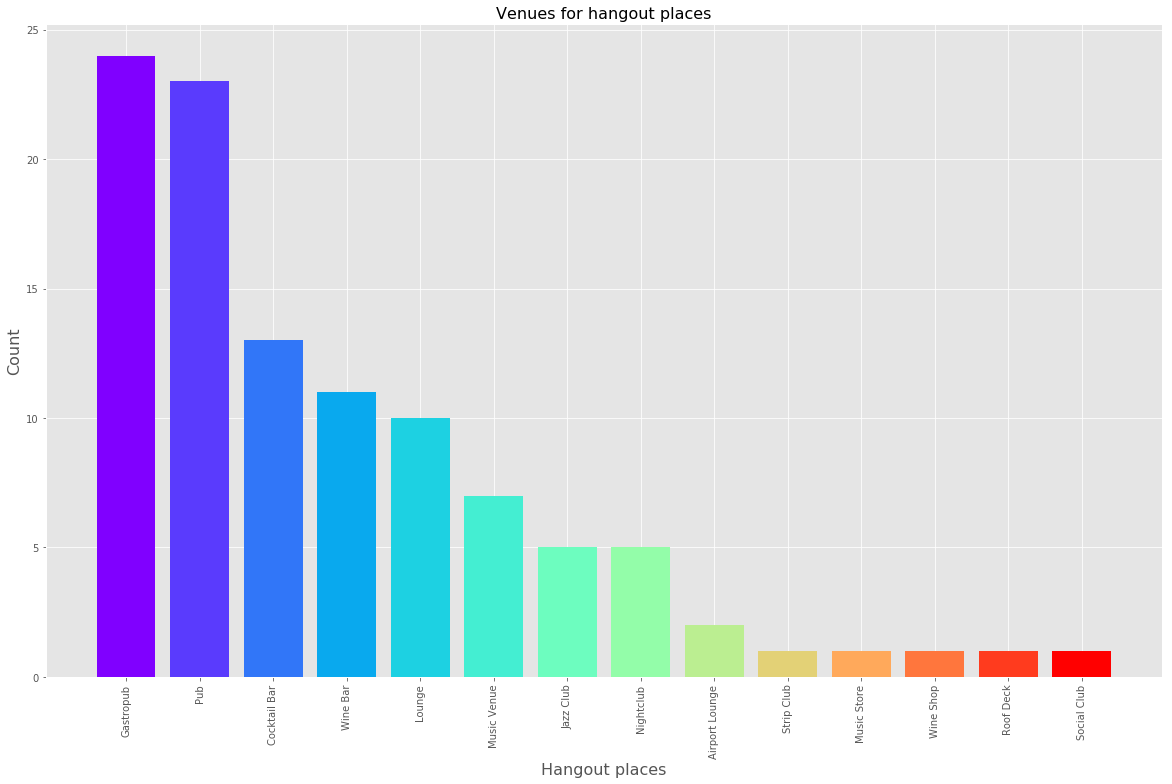

In [114]:
venue_distribution_ho = Places_ho['Venue Category'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution_ho.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Hangout places", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Venues for hangout places", fontsize = 16)
plt.bar(venue_distribution_ho.index, venue_distribution_ho.values, color = colors)

<BarContainer object of 83 artists>

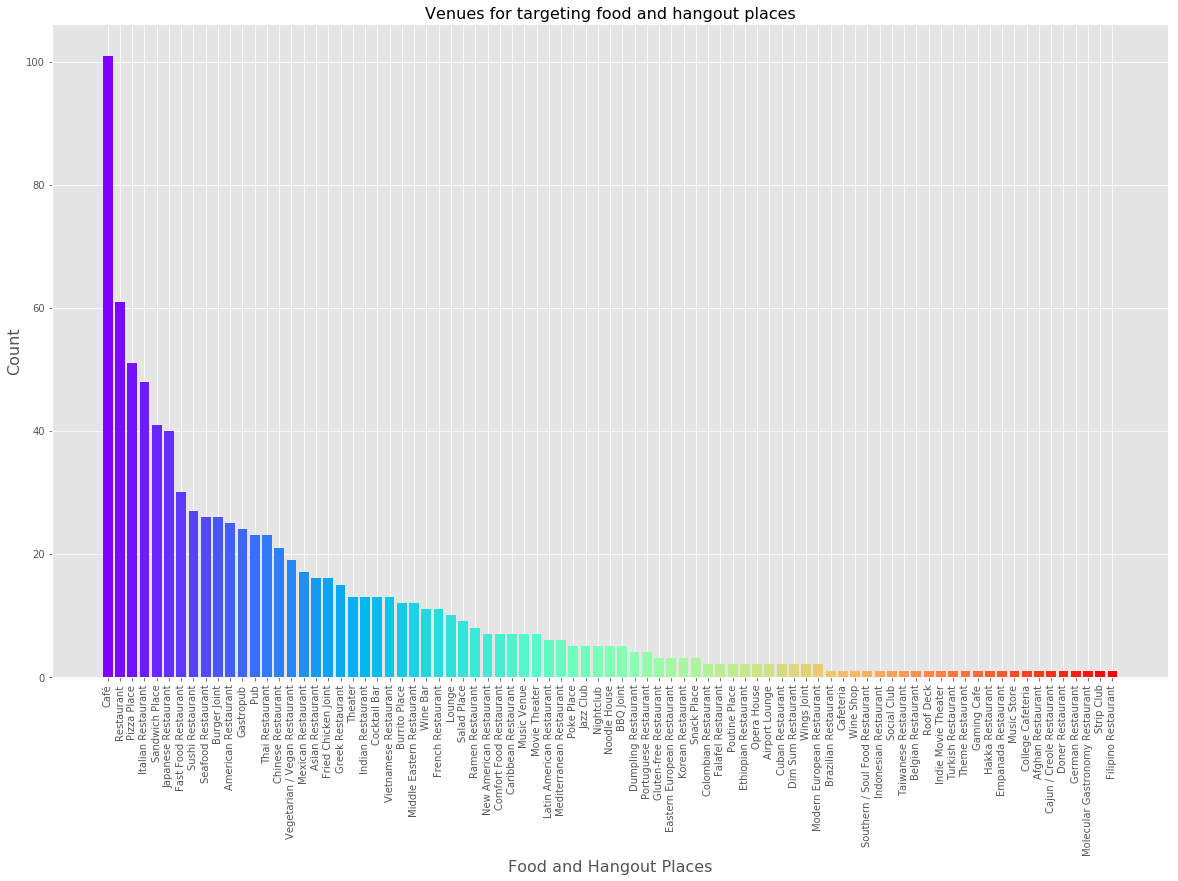

In [108]:
venue_distribution_res = Places_food['Venue Category'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution_res.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Food and Hangout Places", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Venues for targeting food and hangout places", fontsize = 16)
plt.bar(venue_distribution_res.index, venue_distribution_res.values, color = colors)

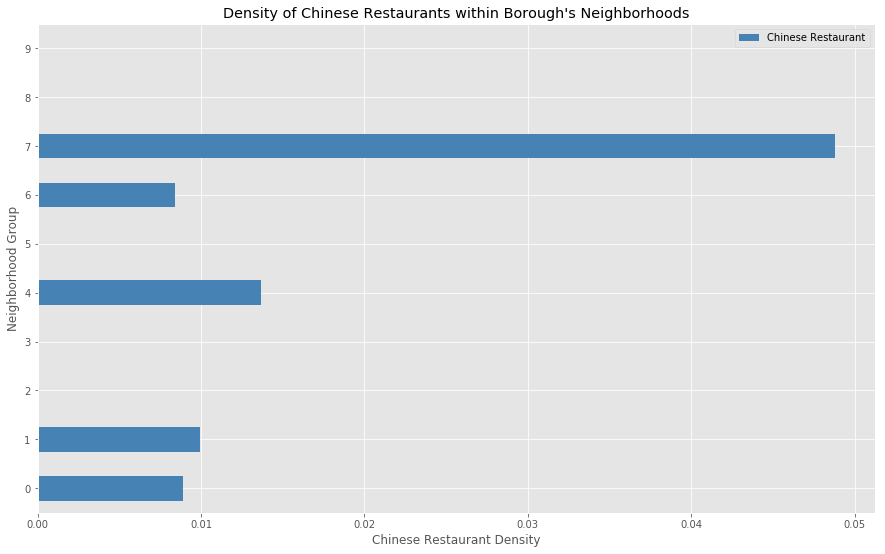

In [112]:
# generate plot
to_chinese.plot(kind='barh', figsize=(15, 9), color='steelblue')
plt.xlabel('Chinese Restaurant Density')
plt.ylabel('Neighborhood Group') # add y-label to the plot
plt.title("Density of Chinese Restaurants within Borough's Neighborhoods")

plt.show()


In [173]:
to_chinese

Neighborhoods  Chinese Restaurant  Total     Count  Clus_km
0   Central Toronto            0.008929      3  6.008929        1
1  Downtown Toronto            0.009924      3  6.009924        1
2      East Toronto            0.000000      3  6.000000        0
3         East York            0.000000      3  6.000000        0
4         Etobicoke            0.013699      3  6.013699        1
5       Mississauga            0.000000      3  6.000000        0
6        North York            0.008403      3  6.008403        1
7       Scarborough            0.048780      3  6.048780        2
8      West Toronto            0.000000      3  6.000000        0
9              York            0.000000      3  6.000000        0

In [224]:
# download countries geojson file
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/world_countries.json -O world_countries.json
    
print('GeoJSON file downloaded!')


GeoJSON file downloaded!


In [225]:
world_geo = r'world_countries.json'

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(to_chinese['Chinese Restaurant'].min(),
                              to_chinese['Chinese Restaurant'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# let Folium determine the scale.
toronto_mapp = folium.Map(location=[43.653963, -79.387207], zoom_start=2, tiles='Mapbox Bright')
toronto_map.choropleth(
    geo_data=world_geo,
    data=to_chinese,
    columns=['Neighborhoods', 'Chinese Restaurant'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Chinese Restaurants in Toronto',
    reset=True
)
toronto_map


In [197]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from matplotlib import pyplot 
import seaborn 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

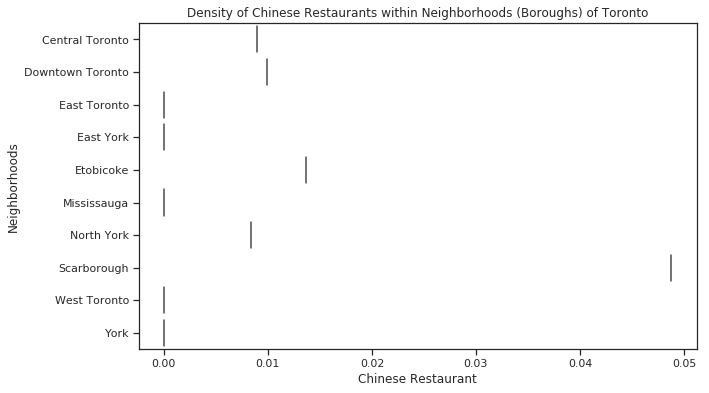

In [227]:
fig, ax = pyplot.subplots(figsize =(10, 6)) 
ax = sns.violinplot(x="Chinese Restaurant", y="Neighborhoods", data=to_chinese)
plt.title("Density of Chinese Restaurants within Neighborhoods (Boroughs) of Toronto")

plt.show()


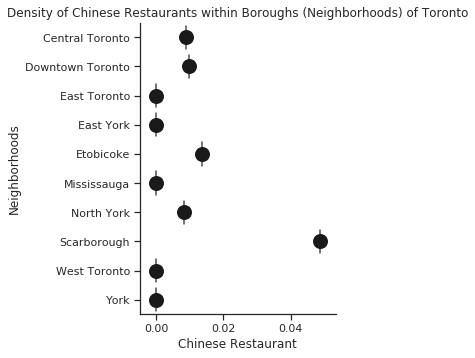

In [210]:
g = sns.catplot(x="Chinese Restaurant", y="Neighborhoods", kind="violin", inner=None, data=to_chinese)
sns.swarmplot(x="Chinese Restaurant", y="Neighborhoods", color="k", size=15, data=to_chinese, ax=g.ax);
plt.title("Density of Chinese Restaurants within Boroughs (Neighborhoods) of Toronto")

plt.show()


# Results and Discussion <a name="results"></a>

•	Results section where you discuss the results.
•	Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.

# Conclusion <a name="conclusion"></a>

Having wrangled the wiki page data, explored, segmented and clustered neighborhoods in the city of Toronto, the following have been observed. While Cluster seems unique in its own way, Cluster 2 has fast food Restaurants and also coffee shops. Its second most common venues are Breakfast Spots and Clothing Stores. Clusters 3 and 4 located in the downtown area has most comonnly coffee shops and Restaurants. Cluster 3 most common venue is the parks with more open spaces. Cluster 5 has homogenic foods in the first 3 common places, maybe down to inhabitants thereof. 